# <center>ECE 542 Final Project</center>

## <center>Exploring Vision-Based Models for Land-Usage Classification Using Remote Sensing Imagery Data</center>

### <center> Presented By - Group 163</center>

<center>Anirudh Kaluri (akaluri)</center>

<center>Rishi Singhal (rsingha4)</center>

<center>Yazhuo Gao (ygao46)</center>

### Motivation - Why Land Use Classification?

● Understanding land-use patterns is crucial for sustainable resource management, urban planning, and environmental conservation.

● When combined with deep learning, these images offer insights for disaster recovery, resource allocation, precision agriculture, biodiversity monitoring, and infrastructure planning. A core challenge is accurately classifying land-use patterns from satellite imagery.

### Problem Statement
● Enhance the understanding of deep learning (DL) models' usefulness for land-use classification using three vision-based neural networks to classify remote sensing images.

### Dataset Used
● To explore the task of land-use classification, we use the UC-Merced Land-Use Dataset available at Kaggle [1]. 

● It contains satellite images of different urban regions in the US extracted from USGS National Map Urban Area Imagery collection.

### Input & Output of the Task

● Input:

A RGB satellite image representing a region of land use, e.g. forest, river. The majority of image size is 256x256. Non 256x256 images are distributed across multiple classes. We will resize them to 256x256 before training and testing our models.

● Output:

A predicted class label (e.g. forest, river) corresponding to the land-use image feeded to the network.

### Prior Work

● Rishi has previously worked with vision based models for different classification tasks.

## Import libraries to be Used

In [1]:
## Standard libraries
import os
import sys
import json
import math
import random
import numpy as np 
import subprocess
import copy
import time

## Imports for plotting
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_theme()
from PIL import Image

## Progress bar
from tqdm.notebook import tqdm

## typing
from typing import (
    Any,
    Callable,
    Dict,
    List,
    Optional,
    Sequence,
    Set,
    Tuple,
    Type,
    Union,
)

try:
    from typing import Literal
except ImportError:
    from typing_extensions import Literal

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## PyTorch Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: 
    !pip install --quiet pytorch-lightning>=1.6
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

## sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Install additional packages
!pip install mmengine
!pip install kaggle
!pip install kagglehub
!pip install torchsummary

### Identify the system

In [3]:
import platform
from mmengine.utils.dl_utils import collect_env
from pprint import pprint

print("=" * 40, "System Information", "=" * 40)
uname = platform.uname()
print(f"System: {uname.system}")
print(f"Node Name: {uname.node}")
print(f"Release: {uname.release}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}")
print(f"Processor: {uname.processor}")

print("=" * 40, "Environment Information", "=" * 40)
my_env = collect_env()
pprint(my_env)

======================================== System Information ========================================
System: Linux
Node Name: jupyter-yazhuog
Release: 5.15.0-119-generic
Version: #129-Ubuntu SMP Fri Aug 2 19:25:20 UTC 2024
Machine: x86_64
Processor: x86_64
======================================== Environment Information ========================================
OrderedDict([('sys.platform', 'linux'),
             ('Python',
              '3.11.8 | packaged by conda-forge | (main, Feb 16 2024, '
              '20:53:32) [GCC 12.3.0]'),
             ('CUDA available', True),
             ('MUSA available', False),
             ('numpy_random_seed', 2147483648),
             ('GPU 0,1', 'NVIDIA A100-SXM4-40GB'),
             ('CUDA_HOME', None),
             ('GCC', 'gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0'),
             ('PyTorch', '2.2.0+cu121'),
             ('PyTorch compiling details',
              'PyTorch built with:\n'
              '  - GCC 9.3\n'
              '  - C++ Versio

In [4]:
# Setting the seed
pl.seed_everything(42)

NUM_WORKERS = os.cpu_count()
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = True

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Seed set to 42


Device: cuda:0
Number of workers: 64


## Prepare Datasets

In [5]:
# Path to the folder where the datasets are/should be downloaded 
DATASET_PATH = "./data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./checkpoint/ece542_final_proj"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

In [6]:
# # Download dataset (need username and key to login)
# os.environ['KAGGLE_USERNAME'] = "yazhuog"  # User name
# os.environ['KAGGLE_KEY'] = "04b3533417b01ece0557f2e5f21a4477"  # Password or API token

# import kaggle
# kaggle.api.dataset_download_files("abdulhasibuddin/uc-merced-land-use-dataset", path=DATASET_PATH, unzip=True)

In [7]:
# Download dataset without login
import kagglehub

# Download latest version
DATASET_PATH = kagglehub.dataset_download("abdulhasibuddin/uc-merced-land-use-dataset")

print("Path to dataset files:", DATASET_PATH)

Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/abdulhasibuddin/uc-merced-land-use-dataset/versions/1


Now we have the local address to access dataset. Let's load these data and store them into variables.

In [8]:
classname = os.listdir(f"{DATASET_PATH}/UCMerced_LandUse/Images")
path_to_image = f"{DATASET_PATH}/UCMerced_LandUse/Images"
img_paths = []
classes_img = []
for cls in classname:
    path_to_cls_img = os.listdir(f"{DATASET_PATH}/UCMerced_LandUse/Images/{cls}")
    for sub in path_to_cls_img:
        img_paths.append(f"{DATASET_PATH}/UCMerced_LandUse/Images/{cls}/{sub}")
        classes_img.append(cls)

In [9]:
img_paths[0],classes_img[0]

('/home/jovyan/.cache/kagglehub/datasets/abdulhasibuddin/uc-merced-land-use-dataset/versions/1/UCMerced_LandUse/Images/runway/runway32.tif',
 'runway')

### Defining Pipeline for image

It would be nice to use data augmentation for our dataset to make our model more generative.
Accordingly select approaches to modify input data.

In [10]:
Transform_pipeline = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images horizontally with 50% probability (74%)
    transforms.RandomRotation(degrees=30),  # Rotate images randomly within ±30 degrees (74%)
    # transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),  # Crop images randomly (68%)
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, etc. (65%)
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Apply random translation (72%)
    # transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Apply random perspective transformations (69%)
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

### Loading DataLoader and Custom Data Set

In [11]:
class Dataset_class(data.Dataset):
    def __init__(self,paths,labels,transform):
        super().__init__()
        self.paths = paths
        self.transform=transform
        self.labels = labels
        self.length = labels.shape[0]
        
    def __len__(self):
        return self.length
    
    def __getitem__(self,idx):
        # print("This is getitem idx :",idx,type(idx))
        img_path = self.paths[idx]
        img = Image.open(img_path)
        img = self.transform(img)
        # print(type(img),img.shape)
        label = self.labels[idx]
        return img,label

To understand our dataset, let's print class information with respect to images.

In [12]:
# Label image categories
img_category = np.unique(classes_img)
labelencode = LabelEncoder()
labels = labelencode.fit_transform(classes_img)
label_category = np.unique(labels)

In [13]:
print("=" * 10, "Image Categories", "=" * 10)
for i in range(len(np.unique(labels))):
    print(f"{label_category[i]}: {img_category[i]}")

========== Image Categories ==========
0: agricultural
1: airplane
2: baseballdiamond
3: beach
4: buildings
5: chaparral
6: denseresidential
7: forest
8: freeway
9: golfcourse
10: harbor
11: intersection
12: mediumresidential
13: mobilehomepark
14: overpass
15: parkinglot
16: river
17: runway
18: sparseresidential
19: storagetanks
20: tenniscourt


Before going to model architecture, we should construct our train and validation dataset. Here we split them as train set (75%) and validation set (25%) to make sure balance. 

For data loaders, we apply a batch size of 16 for mini batches. RAM distributor is also activated and splitted to accelerate our training process.

In [14]:
x_train,x_test,y_train,y_test = train_test_split(img_paths,labels,test_size = 0.25,random_state = 42)
train_dataset = Dataset_class(x_train,y_train,Transform_pipeline)
test_dataset = Dataset_class(x_test,y_test,Transform_pipeline)

batch_size = 16

train_loader= data.DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers=int(NUM_WORKERS*0.75), 
    pin_memory=True,
    persistent_workers=True
)

val_loader = data.DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers=int(NUM_WORKERS*0.25), 
    pin_memory=True,
    persistent_workers=True
)

### Define BaseCNN Structure

We'll use CNN as our baseline model. The below CNN consists of 5 2D-convolution layers with BatchNorm, ReLU, and AvePool. A classifier with dropout is followed at last to handle the features and output.

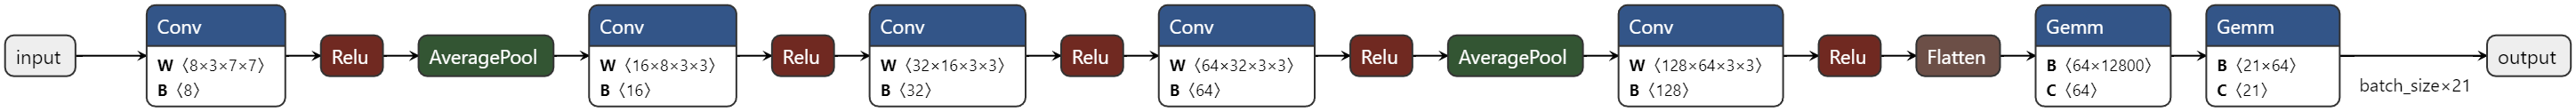

In [15]:
class BaseCNN(nn.Module):
    def __init__(self, in_channels=3, hid_dim=8, dropout=0.3):
        super().__init__()
        self.relu=nn.ReLU()
        self.drop = nn.Dropout(dropout)
        self.conv1=nn.Conv2d(in_channels, hid_dim, kernel_size=(7,7), stride=3, padding=0)
        self.bn1=nn.BatchNorm2d(8)
        self.mp1=nn.AvgPool2d(kernel_size=(2,2),stride=2,padding=0)
        
        self.conv2=nn.Conv2d(hid_dim, hid_dim*2, kernel_size=(3,3), stride=1, padding=1)
        self.bn2=nn.BatchNorm2d(16)
        
        self.conv3=nn.Conv2d(hid_dim*2, hid_dim*4, kernel_size=(3,3), stride=1, padding=1)
        self.bn3=nn.BatchNorm2d(32)

        self.conv4=nn.Conv2d(hid_dim*4, hid_dim*8, kernel_size=(3,3), stride=1, padding=1)
        self.bn4=nn.BatchNorm2d(64)
        
        self.mp2=nn.AvgPool2d(kernel_size=(2,2),stride=2,padding=0)
        
        self.conv5=nn.Conv2d(hid_dim*8, hid_dim*16, kernel_size=(3,3), stride=2, padding=0)
        self.bn5=nn.BatchNorm2d(hid_dim*16)

        self.flatten=nn.Flatten()

        self.lin1=nn.Linear(in_features=12800, out_features=64)
        self.lin2 = nn.Linear(in_features = 64, out_features = 21)

        self.softmax = nn.Softmax(dim=1)
    
    def forward(self,x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        x=self.mp1(x)
        
        x=self.conv2(x)
        x=self.bn2(x)
        x=self.relu(x)
        
        x=self.conv3(x)
        x=self.bn3(x)
        x=self.relu(x)
        
        x=self.conv4(x)
        x=self.bn4(x)
        x=self.relu(x)
        x=self.mp2(x)
        
        x=self.conv5(x)
        x=self.bn5(x)
        x=self.relu(x)
        
        x=self.flatten(x)
        x=self.drop(x)
        x=self.lin1(x)
        x=self.drop(x)
        x=self.lin2(x)
        # x=self.drop(x)

        return x        

In [16]:
from torchsummary import summary
torch_device = torch.device("cpu")
model_check = BaseCNN().to(torch_device)
summary(model_check, input_size=(3, 256, 256), device=str(torch_device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 84, 84]           1,184
       BatchNorm2d-2            [-1, 8, 84, 84]              16
              ReLU-3            [-1, 8, 84, 84]               0
         AvgPool2d-4            [-1, 8, 42, 42]               0
            Conv2d-5           [-1, 16, 42, 42]           1,168
       BatchNorm2d-6           [-1, 16, 42, 42]              32
              ReLU-7           [-1, 16, 42, 42]               0
            Conv2d-8           [-1, 32, 42, 42]           4,640
       BatchNorm2d-9           [-1, 32, 42, 42]              64
             ReLU-10           [-1, 32, 42, 42]               0
           Conv2d-11           [-1, 64, 42, 42]          18,496
      BatchNorm2d-12           [-1, 64, 42, 42]             128
             ReLU-13           [-1, 64, 42, 42]               0
        AvgPool2d-14           [-1, 64,

## Train with Customized mode

Next is the procedure to train our model. We'll treat learning rate as hyperparameter and plug it in both Adam and SGD optimizer to compare performance.

In [17]:
def train_one_epoch(model, loss_module, optimizer, data_loader, loop):
    model.train()
    true_preds, total_loss = 0, 0.0
    total_samples = 0

    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)

        pred = model(imgs)
        loss = loss_module(pred, labels)
        total_loss += loss.item() * imgs.size(0)
        true_preds += (torch.argmax(pred, dim=1) == labels).sum().item()
        total_samples += imgs.size(0)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss = total_loss / total_samples
        running_acc = true_preds / total_samples

        # Update tqdm progress
        loop.set_postfix(train_loss=round(running_loss, 4), train_acc=f"{round(running_acc*100, 2)}%")

    epoch_loss = total_loss / total_samples
    epoch_acc = true_preds / total_samples
    return epoch_loss, epoch_acc


In [18]:
@torch.no_grad()
def test_model(model, loss_module, data_loader, loop):
    model.eval()  # Set model to evaluation mode
    true_preds, total_samples = 0.0, 0
    total_loss = 0.0

    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs) 
        loss = loss_module(outputs, labels)  # Compute loss
        total_loss += loss.item() * labels.size(0)  # Sum loss over batch
        preds = outputs.argmax(dim=1) 

        true_preds += (preds == labels).sum().item()  
        total_samples += labels.size(0)  

        running_loss = total_loss / total_samples
        running_acc = true_preds / total_samples

        # Update tqdm progress
        loop.set_postfix(val_loss=round(running_loss, 4), val_acc=f"{round(running_acc*100, 2)}%")

    accuracy = true_preds / total_samples  # Compute accuracy percentage
    val_loss = total_loss / total_samples  # Average loss per sample
    return accuracy, val_loss

In [19]:
def save_model(model, model_name, root_dir=CHECKPOINT_PATH):
    os.makedirs(root_dir, exist_ok=True)  # Ensure the directory exists
    model_path = os.path.join(root_dir, f"{model_name}.pt")
    
    torch.save(model.state_dict(), model_path)
    print(f"Best model saved to {model_path}")

def load_model(model, model_name, root_dir=CHECKPOINT_PATH):
    model_path = os.path.join(root_dir, f"{model_name}.pt")
    
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"No checkpoint found at {model_path}")
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    print(f"Best model loaded from {model_path}")
    return model

In [20]:
def evaluate(model):
    model.eval()

    # Collect predictions and true labels from validation set
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
    
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    print("\n=== Final Evaluation on Best Model ===")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print("=====================================\n")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    labels = sorted(set(all_labels))
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix (Validation Set)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

In [21]:
def train_model(model, optimizer, loss_module, train_data_loader, val_data_loader, num_epochs=25, model_name="MyModel"):
    model.to(device)
    best_val_acc = -1.0
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(1, num_epochs + 1):
        # Create tqdm progress bar here and pass it to train_one_epoch
        train_loop = tqdm(train_data_loader,  leave=False, desc=f"Epoch {epoch}/{num_epochs} ")
        train_loss, train_acc = train_one_epoch(model, loss_module, optimizer, train_data_loader, train_loop)

        print_data = 0
        val_loop = tqdm(val_data_loader, leave=False, desc=f"Validating Epoch {epoch} ")
        acc, loss = test_model(model, loss_module, val_data_loader, val_loop)
        
        # Save model when a higher accuracy found
        if acc > best_val_acc:
            best_val_acc = acc
            save_model(model, model_name, CHECKPOINT_PATH)
            print_data = 1

        if print_data or epoch % 10 == 0 or epoch == num_epochs:
            print(
                f"[Epoch {epoch:2d}] Training loss: {train_loss:05.3f}, Training accuracy: {train_acc*100.0:05.2f}%, Validation loss: {loss:05.3f}, Validation accuracy: {acc*100.0:05.2f}%, Best validation accuracy: {best_val_acc*100.0:05.2f}%"
            )
            print("--------------------------------------------------")

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(loss)
        val_accs.append(acc)

    model = load_model(model, model_name, CHECKPOINT_PATH)
    return model, train_losses, train_accs, val_losses, val_accs


In [22]:
# Calculate size of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters()) / 1e6

### Adam Optimizer

In [23]:
# Start training the model
model_ucnn_Adam=BaseCNN(in_channels=3,
                hid_dim=8,
                dropout=0.3
               ).to(device)
loss_module_Adam=nn.CrossEntropyLoss()
optimizer_Adam=torch.optim.Adam(params=model_ucnn_Adam.parameters(), lr=3e-4, weight_decay=1e-4)
num_epochs_Adam=100

print(f"model ucnn created: {count_parameters(model_ucnn_Adam):05.3f}M")
train_start_Adam = time.time()
model_ucnn_Adam, train_losses_Adam, train_accs_Adam, val_losses_Adam, val_accs_Adam=train_model(model_ucnn_Adam, optimizer_Adam, loss_module_Adam, train_loader, val_loader, num_epochs_Adam, model_name="myBaseCNN_Adam")
train_end_Adam = time.time()

model ucnn created: 0.920M


Epoch 1/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 1 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_Adam.pt
[Epoch  1] Training loss: 2.577, Training accuracy: 24.19%, Validation loss: 2.061, Validation accuracy: 36.95%, Best validation accuracy: 36.95%
--------------------------------------------------


Epoch 2/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 2 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_Adam.pt
[Epoch  2] Training loss: 2.031, Training accuracy: 39.11%, Validation loss: 2.021, Validation accuracy: 37.71%, Best validation accuracy: 37.71%
--------------------------------------------------


Epoch 3/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 3 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_Adam.pt
[Epoch  3] Training loss: 1.781, Training accuracy: 46.60%, Validation loss: 1.591, Validation accuracy: 51.24%, Best validation accuracy: 51.24%
--------------------------------------------------


Epoch 4/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 4 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 5 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_Adam.pt
[Epoch  5] Training loss: 1.403, Training accuracy: 58.03%, Validation loss: 1.425, Validation accuracy: 56.38%, Best validation accuracy: 56.38%
--------------------------------------------------


Epoch 6/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 6 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 7 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_Adam.pt
[Epoch  7] Training loss: 1.168, Training accuracy: 63.37%, Validation loss: 1.303, Validation accuracy: 58.67%, Best validation accuracy: 58.67%
--------------------------------------------------


Epoch 8/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 8 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_Adam.pt
[Epoch  8] Training loss: 1.091, Training accuracy: 66.35%, Validation loss: 1.118, Validation accuracy: 65.14%, Best validation accuracy: 65.14%
--------------------------------------------------


Epoch 9/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 9 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 10 :   0%|          | 0/33 [00:00<?, ?it/s]

[Epoch 10] Training loss: 0.972, Training accuracy: 69.97%, Validation loss: 1.134, Validation accuracy: 64.38%, Best validation accuracy: 65.14%
--------------------------------------------------


Epoch 11/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 11 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 12 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_Adam.pt
[Epoch 12] Training loss: 0.873, Training accuracy: 73.08%, Validation loss: 1.065, Validation accuracy: 67.62%, Best validation accuracy: 67.62%
--------------------------------------------------


Epoch 13/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 13 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 14 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_Adam.pt
[Epoch 14] Training loss: 0.677, Training accuracy: 76.89%, Validation loss: 1.075, Validation accuracy: 68.00%, Best validation accuracy: 68.00%
--------------------------------------------------


Epoch 15/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 15 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 16/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 16 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 17/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 17 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_Adam.pt
[Epoch 17] Training loss: 0.667, Training accuracy: 79.81%, Validation loss: 1.074, Validation accuracy: 68.95%, Best validation accuracy: 68.95%
--------------------------------------------------


Epoch 18/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 18 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_Adam.pt
[Epoch 18] Training loss: 0.613, Training accuracy: 79.68%, Validation loss: 0.904, Validation accuracy: 72.95%, Best validation accuracy: 72.95%
--------------------------------------------------


Epoch 19/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 19 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 20/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 20 :   0%|          | 0/33 [00:00<?, ?it/s]

[Epoch 20] Training loss: 0.605, Training accuracy: 79.56%, Validation loss: 0.966, Validation accuracy: 71.05%, Best validation accuracy: 72.95%
--------------------------------------------------


Epoch 21/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 21 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 22/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 22 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 23/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 23 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_Adam.pt
[Epoch 23] Training loss: 0.479, Training accuracy: 84.51%, Validation loss: 0.883, Validation accuracy: 74.29%, Best validation accuracy: 74.29%
--------------------------------------------------


Epoch 24/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 24 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 25/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 25 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 26/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 26 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 27/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 27 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_Adam.pt
[Epoch 27] Training loss: 0.398, Training accuracy: 87.05%, Validation loss: 0.862, Validation accuracy: 76.00%, Best validation accuracy: 76.00%
--------------------------------------------------


Epoch 28/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 28 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 29/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 29 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 30/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 30 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_Adam.pt
[Epoch 30] Training loss: 0.355, Training accuracy: 87.62%, Validation loss: 0.809, Validation accuracy: 76.38%, Best validation accuracy: 76.38%
--------------------------------------------------


Epoch 31/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 31 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 32/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 32 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_Adam.pt
[Epoch 32] Training loss: 0.351, Training accuracy: 88.19%, Validation loss: 0.817, Validation accuracy: 77.14%, Best validation accuracy: 77.14%
--------------------------------------------------


Epoch 33/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 33 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 34/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 34 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 35/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 35 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 36/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 36 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 37/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 37 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 38/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 38 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_Adam.pt
[Epoch 38] Training loss: 0.313, Training accuracy: 88.51%, Validation loss: 0.835, Validation accuracy: 77.71%, Best validation accuracy: 77.71%
--------------------------------------------------


Epoch 39/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 39 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 40/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 40 :   0%|          | 0/33 [00:00<?, ?it/s]

[Epoch 40] Training loss: 0.329, Training accuracy: 89.84%, Validation loss: 0.874, Validation accuracy: 76.38%, Best validation accuracy: 77.71%
--------------------------------------------------


Epoch 41/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 41 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 42/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 42 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 43/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 43 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 44/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 44 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_Adam.pt
[Epoch 44] Training loss: 0.344, Training accuracy: 88.19%, Validation loss: 0.894, Validation accuracy: 77.90%, Best validation accuracy: 77.90%
--------------------------------------------------


Epoch 45/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 45 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_Adam.pt
[Epoch 45] Training loss: 0.284, Training accuracy: 91.17%, Validation loss: 0.688, Validation accuracy: 79.81%, Best validation accuracy: 79.81%
--------------------------------------------------


Epoch 46/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 46 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 47/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 47 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_Adam.pt
[Epoch 47] Training loss: 0.306, Training accuracy: 89.65%, Validation loss: 0.778, Validation accuracy: 80.57%, Best validation accuracy: 80.57%
--------------------------------------------------


Epoch 48/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 48 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 49/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 49 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 50/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 50 :   0%|          | 0/33 [00:00<?, ?it/s]

[Epoch 50] Training loss: 0.259, Training accuracy: 91.62%, Validation loss: 0.847, Validation accuracy: 77.90%, Best validation accuracy: 80.57%
--------------------------------------------------


Epoch 51/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 51 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 52/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 52 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 53/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 53 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 54/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 54 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 55/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 55 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 56/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 56 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 57/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 57 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 58/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 58 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 59/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 59 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 60/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 60 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_Adam.pt
[Epoch 60] Training loss: 0.178, Training accuracy: 93.90%, Validation loss: 0.732, Validation accuracy: 81.71%, Best validation accuracy: 81.71%
--------------------------------------------------


Epoch 61/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 61 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 62/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 62 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_Adam.pt
[Epoch 62] Training loss: 0.174, Training accuracy: 94.16%, Validation loss: 0.718, Validation accuracy: 82.10%, Best validation accuracy: 82.10%
--------------------------------------------------


Epoch 63/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 63 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 64/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 64 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 65/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 65 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 66/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 66 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 67/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 67 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 68/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 68 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 69/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 69 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 70/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 70 :   0%|          | 0/33 [00:00<?, ?it/s]

[Epoch 70] Training loss: 0.174, Training accuracy: 94.35%, Validation loss: 0.820, Validation accuracy: 80.19%, Best validation accuracy: 82.10%
--------------------------------------------------


Epoch 71/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 71 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 72/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 72 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 73/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 73 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 74/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 74 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 75/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 75 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 76/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 76 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 77/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 77 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_Adam.pt
[Epoch 77] Training loss: 0.136, Training accuracy: 95.17%, Validation loss: 0.675, Validation accuracy: 82.86%, Best validation accuracy: 82.86%
--------------------------------------------------


Epoch 78/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 78 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 79/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 79 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 80/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 80 :   0%|          | 0/33 [00:00<?, ?it/s]

[Epoch 80] Training loss: 0.137, Training accuracy: 95.24%, Validation loss: 0.931, Validation accuracy: 79.05%, Best validation accuracy: 82.86%
--------------------------------------------------


Epoch 81/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 81 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 82/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 82 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 83/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 83 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 84/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 84 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_Adam.pt
[Epoch 84] Training loss: 0.130, Training accuracy: 95.87%, Validation loss: 0.603, Validation accuracy: 84.57%, Best validation accuracy: 84.57%
--------------------------------------------------


Epoch 85/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 85 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 86/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 86 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 87/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 87 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 88/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 88 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 89/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 89 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 90/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 90 :   0%|          | 0/33 [00:00<?, ?it/s]

[Epoch 90] Training loss: 0.172, Training accuracy: 94.22%, Validation loss: 0.765, Validation accuracy: 81.52%, Best validation accuracy: 84.57%
--------------------------------------------------


Epoch 91/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 91 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 92/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 92 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 93/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 93 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 94/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 94 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 95/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 95 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 96/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 96 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 97/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 97 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 98/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 98 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 99/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 99 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 100/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 100 :   0%|          | 0/33 [00:00<?, ?it/s]

[Epoch 100] Training loss: 0.126, Training accuracy: 96.32%, Validation loss: 0.796, Validation accuracy: 82.10%, Best validation accuracy: 84.57%
--------------------------------------------------
Best model loaded from ./checkpoint/ece542_final_proj/myBaseCNN_Adam.pt


Training spent: 2min 40.78sec

=== Final Evaluation on Best Model ===
Accuracy:  0.8038
Precision: 0.8093
Recall:    0.8099
F1-score:  0.8021



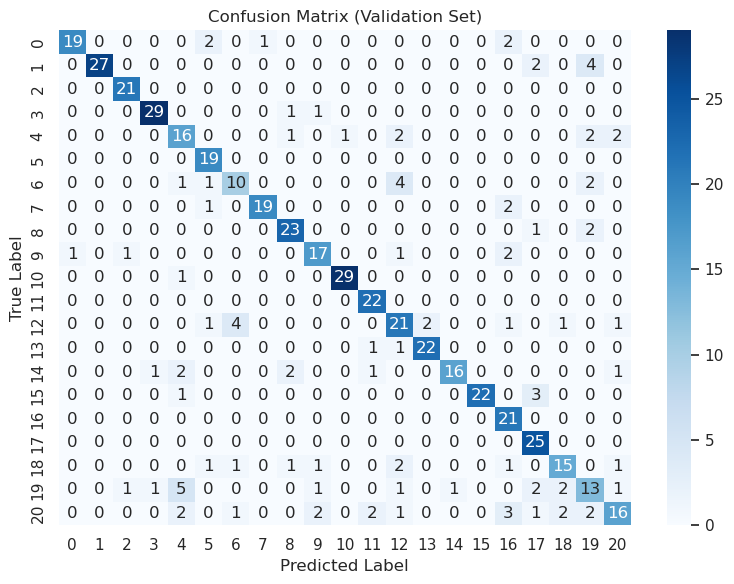

In [24]:
duration_Adam = train_end_Adam-train_start_Adam
minutes_Adam = int(duration_Adam // 60)
seconds_Adam = duration_Adam % 60

if minutes_Adam > 0:
    print(f"Training spent: {minutes_Adam}min {seconds_Adam:.2f}sec")
else:
    print(f"Training spent: {seconds_Adam:.2f}sec")
    
evaluate(model_ucnn_Adam)

In [25]:
# Plot results using curve_fit
from scipy.optimize import curve_fit

def plot_training_curvefit(train_losses, val_losses, train_accs, val_accs):    
    epochs = np.arange(1, len(train_losses) + 1)
    
    # Function to fit polynomial of given degree
    def fit_polynomial(x, y, degree):
        coeffs = np.polyfit(x, y, degree)  # Fit polynomial
        return np.polyval(coeffs, x), coeffs  # Evaluate polynomial
    
    # Choose degree for polynomial fitting
    degree = (len(train_losses) / 10) + 1 
    
    # Fit polynomial curves to the training loss, training accuracy, and validation accuracy
    fitted_loss, coeffs_loss = fit_polynomial(epochs, train_losses, degree)
    fitted_train_acc, coeffs_train_acc = fit_polynomial(epochs, train_accs, degree)
    fitted_val_loss, coeffs_val_loss = fit_polynomial(epochs, val_losses, degree)
    fitted_val_acc, coeffs_val_acc = fit_polynomial(epochs, val_accs, degree)
    
    # Plot comparison
    plt.figure(figsize=(12, 5))
    
    # Plot Fitted Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo', alpha=0.3, label='Original Loss')
    plt.plot(epochs, fitted_loss, 'b-', label='Smoothed Loss', linewidth=2)
    plt.plot(epochs, val_losses, 'ro', alpha=0.3, label='Original Val Loss')
    plt.plot(epochs, fitted_val_loss, 'r-', label='Smoothed Validation Loss', linewidth=2)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Curve-Fitted Training & Validation Loss')
    
    # Plot Fitted Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'bo', alpha=0.3, label='Original Train Acc')
    plt.plot(epochs, fitted_train_acc, 'b-', label='Smoothed Train Acc', linewidth=2)
    plt.plot(epochs, val_accs, 'ro', alpha=0.3, label='Original Val Acc')
    plt.plot(epochs, fitted_val_acc, 'r-', label='Smoothed Val Acc', linewidth=2)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Curve-Fitted Training & Validation Accuracy')
    
    plt.show()

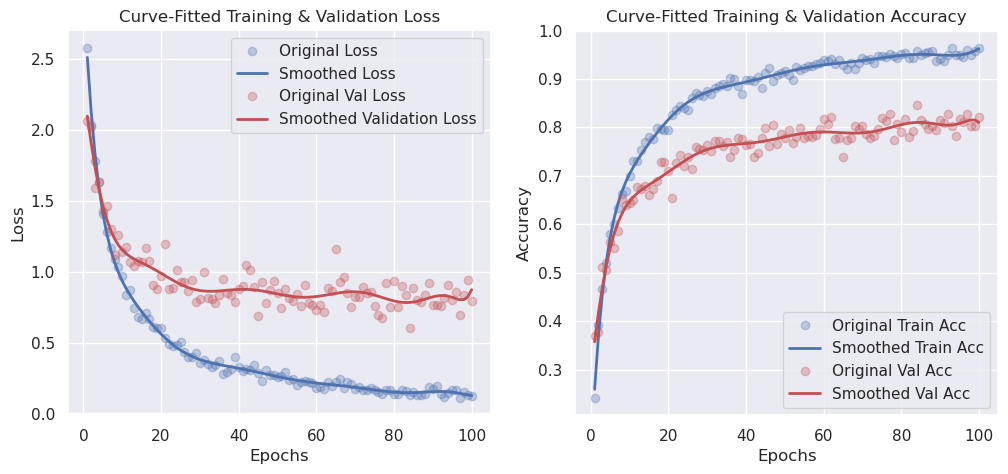

In [26]:
if "train_losses_Adam" in globals():
    plot_training_curvefit(train_losses_Adam, val_losses_Adam, train_accs_Adam, val_accs_Adam)

In [27]:
# Plot results using gaussian_filter
from scipy.ndimage import gaussian_filter1d

def plot_training_gaussian(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    sigma = 2
    
    # Apply Gaussian smoothing
    smoothed_losses = gaussian_filter1d(train_losses, sigma)
    smoothed_train_accs = gaussian_filter1d(train_accs, sigma)
    smoothed_val_losses = gaussian_filter1d(val_losses, sigma)
    smoothed_val_accs = gaussian_filter1d(val_accs, sigma)

    plt.figure(figsize=(12, 5))

    # Plot Smoothed Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo', alpha=0.3, label='Original Loss')
    plt.plot(epochs, smoothed_losses, 'b-', label='Smoothed Training Loss', linewidth=2)
    plt.plot(epochs, val_losses, 'ro', alpha=0.3, label='Original Val Loss')
    plt.plot(epochs, smoothed_val_losses, 'r-', label='Smoothed Validation Loss', linewidth=2)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Gaussian Filtered Training & Validation Loss')

    # Plot Smoothed Accuracy (Training & Validation)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'bo', alpha=0.3, label='Original Train Acc')
    plt.plot(epochs, smoothed_train_accs, 'b-', label='Smoothed Training Accuracy', linewidth=2)
    plt.plot(epochs, val_accs, 'ro', alpha=0.3, label='Original Val Acc')
    plt.plot(epochs, smoothed_val_accs, 'r-', label='Smoothed Validation Accuracy', linewidth=2)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Gaussian Filtered Training & Validation Accuracy')

    plt.show()

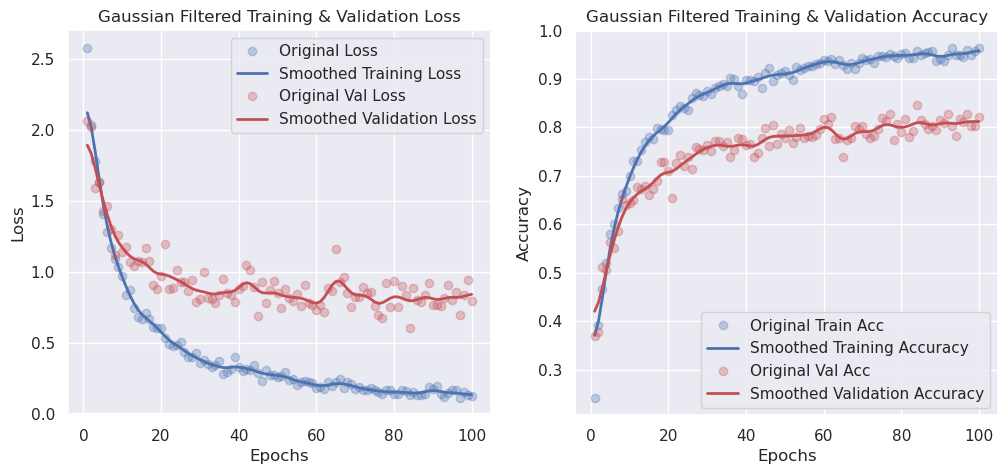

In [28]:
if "train_losses_Adam" in globals(): 
    plot_training_gaussian(train_losses_Adam, val_losses_Adam, train_accs_Adam, val_accs_Adam)

### SGD Optimizer

In [29]:
# Start training the model
model_ucnn_SGD=BaseCNN(in_channels=3,
                hid_dim=8,
                dropout=0.3
               ).to(device)
loss_module_SGD=nn.CrossEntropyLoss()
optimizer_SGD=torch.optim.SGD(params=model_ucnn_SGD.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
num_epochs_SGD=100

print(f"model ucnn created: {count_parameters(model_ucnn_SGD):05.3f}M")
train_start_SGD = time.time()
model_ucnn_SGD, train_losses_SGD, train_accs_SGD, val_losses_SGD, val_accs_SGD=train_model(model_ucnn_SGD, optimizer_SGD, loss_module_SGD, train_loader, val_loader, num_epochs_SGD, model_name="myBaseCNN_SGD")
train_end_SGD = time.time()

model ucnn created: 0.920M


Epoch 1/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 1 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_SGD.pt
[Epoch  1] Training loss: 2.677, Training accuracy: 20.19%, Validation loss: 2.147, Validation accuracy: 33.90%, Best validation accuracy: 33.90%
--------------------------------------------------


Epoch 2/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 2 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_SGD.pt
[Epoch  2] Training loss: 2.098, Training accuracy: 35.24%, Validation loss: 1.889, Validation accuracy: 44.38%, Best validation accuracy: 44.38%
--------------------------------------------------


Epoch 3/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 3 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 4 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_SGD.pt
[Epoch  4] Training loss: 1.674, Training accuracy: 46.22%, Validation loss: 1.663, Validation accuracy: 48.95%, Best validation accuracy: 48.95%
--------------------------------------------------


Epoch 5/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 5 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_SGD.pt
[Epoch  5] Training loss: 1.494, Training accuracy: 51.87%, Validation loss: 1.525, Validation accuracy: 53.14%, Best validation accuracy: 53.14%
--------------------------------------------------


Epoch 6/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 6 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_SGD.pt
[Epoch  6] Training loss: 1.314, Training accuracy: 58.92%, Validation loss: 1.457, Validation accuracy: 56.19%, Best validation accuracy: 56.19%
--------------------------------------------------


Epoch 7/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 7 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 8 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_SGD.pt
[Epoch  8] Training loss: 1.158, Training accuracy: 62.92%, Validation loss: 1.318, Validation accuracy: 56.95%, Best validation accuracy: 56.95%
--------------------------------------------------


Epoch 9/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 9 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_SGD.pt
[Epoch  9] Training loss: 1.111, Training accuracy: 65.02%, Validation loss: 1.299, Validation accuracy: 57.71%, Best validation accuracy: 57.71%
--------------------------------------------------


Epoch 10/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 10 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_SGD.pt
[Epoch 10] Training loss: 0.991, Training accuracy: 68.25%, Validation loss: 1.305, Validation accuracy: 62.29%, Best validation accuracy: 62.29%
--------------------------------------------------


Epoch 11/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 11 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 12 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_SGD.pt
[Epoch 12] Training loss: 0.976, Training accuracy: 69.40%, Validation loss: 1.054, Validation accuracy: 67.05%, Best validation accuracy: 67.05%
--------------------------------------------------


Epoch 13/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 13 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 14 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 15/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 15 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_SGD.pt
[Epoch 15] Training loss: 0.764, Training accuracy: 74.73%, Validation loss: 1.034, Validation accuracy: 69.14%, Best validation accuracy: 69.14%
--------------------------------------------------


Epoch 16/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 16 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_SGD.pt
[Epoch 16] Training loss: 0.695, Training accuracy: 77.90%, Validation loss: 0.971, Validation accuracy: 69.90%, Best validation accuracy: 69.90%
--------------------------------------------------


Epoch 17/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 17 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_SGD.pt
[Epoch 17] Training loss: 0.603, Training accuracy: 79.75%, Validation loss: 0.888, Validation accuracy: 71.05%, Best validation accuracy: 71.05%
--------------------------------------------------


Epoch 18/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 18 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_SGD.pt
[Epoch 18] Training loss: 0.654, Training accuracy: 79.37%, Validation loss: 0.874, Validation accuracy: 72.57%, Best validation accuracy: 72.57%
--------------------------------------------------


Epoch 19/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 19 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_SGD.pt
[Epoch 19] Training loss: 0.577, Training accuracy: 80.63%, Validation loss: 0.856, Validation accuracy: 72.95%, Best validation accuracy: 72.95%
--------------------------------------------------


Epoch 20/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 20 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_SGD.pt
[Epoch 20] Training loss: 0.600, Training accuracy: 80.57%, Validation loss: 0.812, Validation accuracy: 73.90%, Best validation accuracy: 73.90%
--------------------------------------------------


Epoch 21/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 21 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 22/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 22 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_SGD.pt
[Epoch 22] Training loss: 0.536, Training accuracy: 82.48%, Validation loss: 0.837, Validation accuracy: 76.76%, Best validation accuracy: 76.76%
--------------------------------------------------


Epoch 23/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 23 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 24/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 24 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 25/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 25 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 26/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 26 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 27/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 27 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 28/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 28 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 29/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 29 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 30/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 30 :   0%|          | 0/33 [00:00<?, ?it/s]

[Epoch 30] Training loss: 0.412, Training accuracy: 87.24%, Validation loss: 0.951, Validation accuracy: 75.43%, Best validation accuracy: 76.76%
--------------------------------------------------


Epoch 31/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 31 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_SGD.pt
[Epoch 31] Training loss: 0.436, Training accuracy: 86.03%, Validation loss: 0.810, Validation accuracy: 76.95%, Best validation accuracy: 76.95%
--------------------------------------------------


Epoch 32/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 32 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 33/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 33 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 34/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 34 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 35/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 35 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 36/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 36 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 37/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 37 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_SGD.pt
[Epoch 37] Training loss: 0.326, Training accuracy: 89.14%, Validation loss: 0.720, Validation accuracy: 77.52%, Best validation accuracy: 77.52%
--------------------------------------------------


Epoch 38/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 38 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 39/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 39 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_SGD.pt
[Epoch 39] Training loss: 0.355, Training accuracy: 88.19%, Validation loss: 0.708, Validation accuracy: 79.62%, Best validation accuracy: 79.62%
--------------------------------------------------


Epoch 40/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 40 :   0%|          | 0/33 [00:00<?, ?it/s]

[Epoch 40] Training loss: 0.330, Training accuracy: 89.33%, Validation loss: 0.743, Validation accuracy: 76.95%, Best validation accuracy: 79.62%
--------------------------------------------------


Epoch 41/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 41 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 42/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 42 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 43/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 43 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 44/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 44 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 45/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 45 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_SGD.pt
[Epoch 45] Training loss: 0.288, Training accuracy: 90.79%, Validation loss: 0.692, Validation accuracy: 80.95%, Best validation accuracy: 80.95%
--------------------------------------------------


Epoch 46/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 46 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 47/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 47 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 48/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 48 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 49/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 49 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 50/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 50 :   0%|          | 0/33 [00:00<?, ?it/s]

[Epoch 50] Training loss: 0.262, Training accuracy: 90.79%, Validation loss: 0.713, Validation accuracy: 78.67%, Best validation accuracy: 80.95%
--------------------------------------------------


Epoch 51/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 51 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 52/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 52 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 53/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 53 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_SGD.pt
[Epoch 53] Training loss: 0.256, Training accuracy: 92.19%, Validation loss: 0.655, Validation accuracy: 81.33%, Best validation accuracy: 81.33%
--------------------------------------------------


Epoch 54/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 54 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_SGD.pt
[Epoch 54] Training loss: 0.209, Training accuracy: 92.44%, Validation loss: 0.632, Validation accuracy: 81.90%, Best validation accuracy: 81.90%
--------------------------------------------------


Epoch 55/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 55 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 56/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 56 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 57/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 57 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 58/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 58 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 59/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 59 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 60/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 60 :   0%|          | 0/33 [00:00<?, ?it/s]

[Epoch 60] Training loss: 0.177, Training accuracy: 93.84%, Validation loss: 0.711, Validation accuracy: 81.14%, Best validation accuracy: 81.90%
--------------------------------------------------


Epoch 61/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 61 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 62/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 62 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 63/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 63 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 64/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 64 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 65/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 65 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 66/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 66 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 67/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 67 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 68/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 68 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 69/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 69 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 70/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 70 :   0%|          | 0/33 [00:00<?, ?it/s]

[Epoch 70] Training loss: 0.155, Training accuracy: 95.24%, Validation loss: 0.663, Validation accuracy: 81.52%, Best validation accuracy: 81.90%
--------------------------------------------------


Epoch 71/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 71 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 72/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 72 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 73/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 73 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 74/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 74 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_SGD.pt
[Epoch 74] Training loss: 0.097, Training accuracy: 97.52%, Validation loss: 0.612, Validation accuracy: 83.62%, Best validation accuracy: 83.62%
--------------------------------------------------


Epoch 75/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 75 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 76/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 76 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 77/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 77 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 78/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 78 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 79/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 79 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 80/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 80 :   0%|          | 0/33 [00:00<?, ?it/s]

[Epoch 80] Training loss: 0.127, Training accuracy: 95.11%, Validation loss: 0.688, Validation accuracy: 80.00%, Best validation accuracy: 83.62%
--------------------------------------------------


Epoch 81/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 81 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 82/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 82 :   0%|          | 0/33 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/myBaseCNN_SGD.pt
[Epoch 82] Training loss: 0.112, Training accuracy: 96.25%, Validation loss: 0.572, Validation accuracy: 84.57%, Best validation accuracy: 84.57%
--------------------------------------------------


Epoch 83/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 83 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 84/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 84 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 85/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 85 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 86/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 86 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 87/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 87 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 88/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 88 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 89/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 89 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 90/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 90 :   0%|          | 0/33 [00:00<?, ?it/s]

[Epoch 90] Training loss: 0.132, Training accuracy: 95.24%, Validation loss: 0.679, Validation accuracy: 81.33%, Best validation accuracy: 84.57%
--------------------------------------------------


Epoch 91/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 91 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 92/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 92 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 93/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 93 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 94/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 94 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 95/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 95 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 96/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 96 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 97/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 97 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 98/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 98 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 99/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 99 :   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 100/100 :   0%|          | 0/99 [00:00<?, ?it/s]

Validating Epoch 100 :   0%|          | 0/33 [00:00<?, ?it/s]

[Epoch 100] Training loss: 0.095, Training accuracy: 96.38%, Validation loss: 0.765, Validation accuracy: 81.33%, Best validation accuracy: 84.57%
--------------------------------------------------
Best model loaded from ./checkpoint/ece542_final_proj/myBaseCNN_SGD.pt


Training spent: 2min 40.25sec

=== Final Evaluation on Best Model ===
Accuracy:  0.8305
Precision: 0.8314
Recall:    0.8365
F1-score:  0.8266



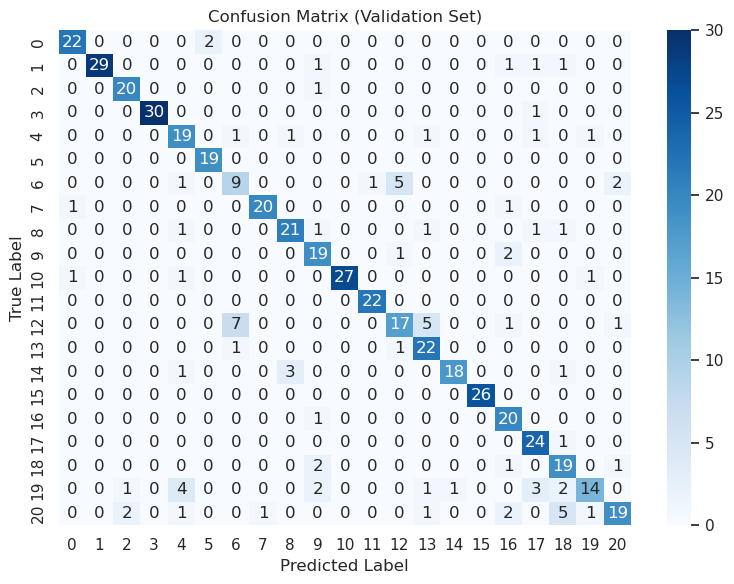

In [30]:
duration_SGD = train_end_SGD-train_start_SGD
minutes_SGD = int(duration_SGD // 60)
seconds_SGD = duration_SGD % 60

if minutes_SGD > 0:
    print(f"Training spent: {minutes_SGD}min {seconds_SGD:.2f}sec")
else:
    print(f"Training spent: {seconds_SGD:.2f}sec")
    
evaluate(model_ucnn_SGD)


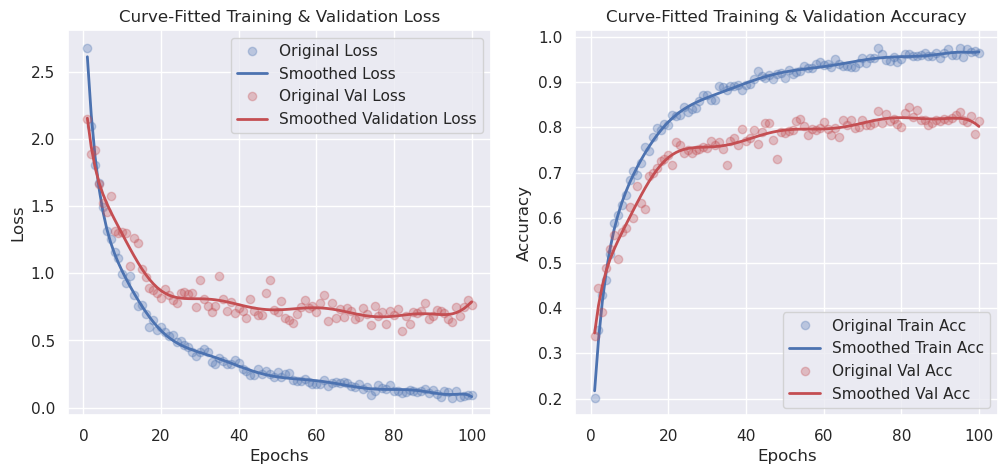

In [31]:
if "train_losses_SGD" in globals():
    plot_training_curvefit(train_losses_SGD, val_losses_SGD, train_accs_SGD, val_accs_SGD)

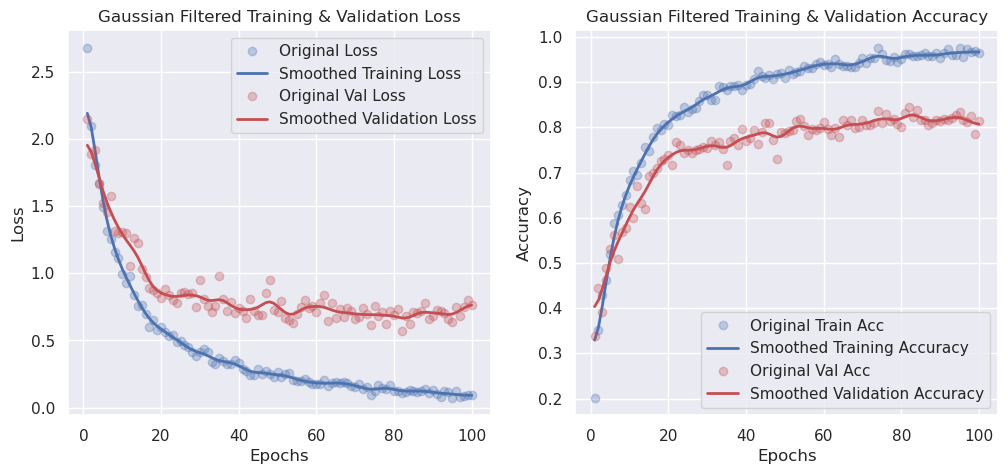

In [32]:
if "train_losses_SGD" in globals(): 
    plot_training_gaussian(train_losses_SGD, val_losses_SGD, train_accs_SGD, val_accs_SGD)

## Train with Pytorch Lightning Mode

Next we'll try using an external training approach from Pytorch Lightning. It provides a convenience way to modify and monitor our training process. Also we'll apply lr scheduler here to compare with our previous experiments.

### Adam Optimaizer with Learning Rate Scheduler

In [33]:
class CNN(pl.LightningModule):
    
    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = BaseCNN(**model_kwargs)
        self.example_input_array = next(iter(train_loader))[0]
        
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=1e-3)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 90], gamma=0.1)
        return [optimizer], [lr_scheduler]   
    
    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self(imgs)  # Forward pass
        loss = F.cross_entropy(preds, labels)  # Cross-entropy loss
        
        acc = (preds.argmax(dim=1) == labels).float().mean()  # Compute accuracy
        
        # Log metrics
        self.log(f"{mode}_loss", loss, prog_bar=True)
        self.log(f"{mode}_acc", acc, prog_bar=True)
        
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

In [34]:
def lightning_evaluate(model, duration):
    model.eval()

    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(model.device), labels.to(model.device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
    
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    minutes = int(duration // 60)
    seconds = duration % 60
    
    result = {
        "val_acc": f"{accuracy:.4f}",
        "val_precision": f"{precision:.4f}",
        "val_recall": f"{recall:.4f}",
        "val_f1": f"{f1:.4f}",
        "time_spent": f"{minutes}min {seconds:.2f}sec"
    }

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    labels = sorted(set(all_labels))
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix (Validation Set)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    return result

In [35]:
def train_model_lightning(max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "CNN"), 
                         devices=1 if str(device)=="cuda:0" else 0,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch")],
                         check_val_every_n_epoch=10)
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "BaseCNN.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = CNN.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42) # To be reproducable
        model = CNN(**kwargs)
        train_start = time.time()
        trainer.fit(model, train_loader, val_loader)
        train_end = time.time()
        duration = train_end-train_start
        
        model = CNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on validation and test set
    # val_result = trainer.test(model, val_loader, verbose=False)[0]["test_acc"]
    # test_result = trainer.test(model, test_loader, verbose=False)
    # result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}
    # result = {"val": f"{val_result*100.0:05.2f}%", "time spent": f"{minutes}min {seconds:.2f}sec"}
    # result = lightning_evaluate(model, duration)

    return model, duration

In [36]:
model_lightning_Adam, duration_Adam = train_model_lightning(model_kwargs={
                                'in_channels': 3,
                                'hid_dim': 8,
                                'dropout': 0.3
                              },
                              lr=3e-4,
                              max_epochs=100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-04-02 02:07:38.768822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743559658.789621   53598 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743559658.796563   53598 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


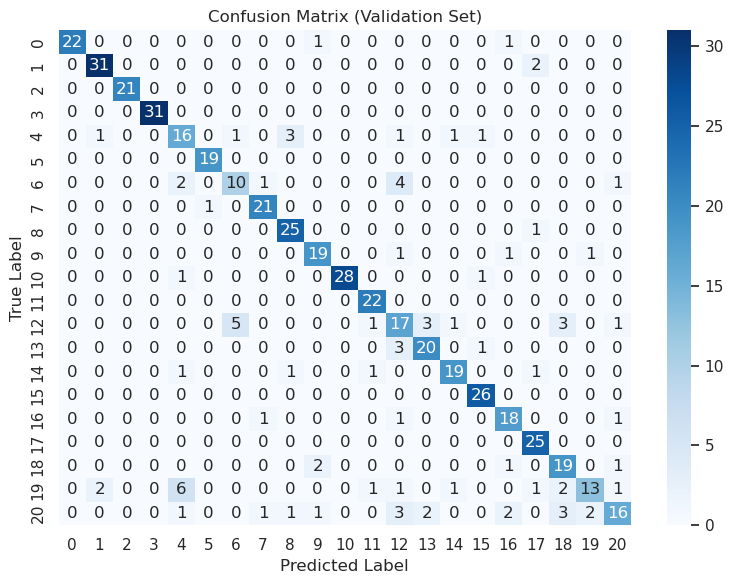

CNN results {'val_acc': '0.8343', 'val_precision': '0.8332', 'val_recall': '0.8403', 'val_f1': '0.8315', 'time_spent': '2min 31.21sec'}


In [37]:
print("CNN results", lightning_evaluate(model_lightning_Adam, duration_Adam))

### SGD Optimaizer with Learning Rate Scheduler

In [38]:
class CNN(pl.LightningModule):
    
    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = BaseCNN(**model_kwargs)
        self.example_input_array = next(iter(train_loader))[0]
        
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=self.hparams.lr,  momentum=0.9, weight_decay=1e-3)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 90], gamma=0.1)
        return [optimizer], [lr_scheduler]   
    
    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self(imgs)  # Forward pass
        loss = F.cross_entropy(preds, labels)  # Cross-entropy loss
        
        acc = (preds.argmax(dim=1) == labels).float().mean()  # Compute accuracy
        
        # Log metrics
        self.log(f"{mode}_loss", loss, prog_bar=True)
        self.log(f"{mode}_acc", acc, prog_bar=True)
        
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

In [39]:
model_lightning_SGD, duration_SGD = train_model_lightning(model_kwargs={
                                'in_channels': 3,
                                'hid_dim': 8,
                                'dropout': 0.3
                              },
                              lr=1e-3,
                              max_epochs=100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params | Mode  | In sizes          | Out sizes
--------------------------------------------------------------------------
0 | model | BaseCNN | 920 K  | train | [16, 3, 256, 256] | [16, 21] 
--------------------------------------------------------------------------
920 K     Trainable params
0         Non-trainable params
920 K     Total params
3.682     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


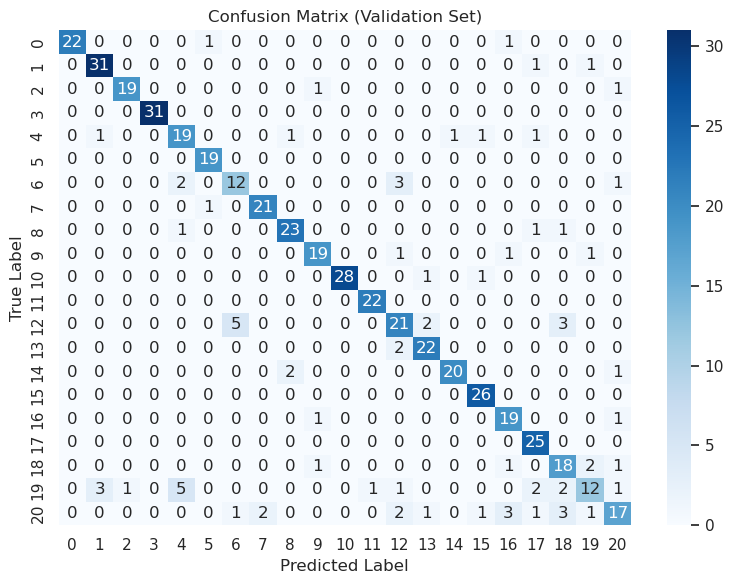

CNN results {'val_acc': '0.8495', 'val_precision': '0.8477', 'val_recall': '0.8555', 'val_f1': '0.8474', 'time_spent': '2min 30.41sec'}


In [40]:
print("CNN results", lightning_evaluate(model_lightning_SGD, duration_SGD))

In [41]:
# !pip install tensorflow
%load_ext tensorboard
%tensorboard --logdir "../checkpoint/ece542_final_proj/CNN"

Reusing TensorBoard on port 6006 (pid 49528), started 1:34:10 ago. (Use '!kill 49528' to kill it.)

### Reference

[1] UC Merced Land Use Dataset. Available:

https://www.kaggle.com/datasets/abdulhasibuddin/uc-merced-land-use-dataset/data.